In [1]:
!pip install awswrangler

     |████████████████████████████████| 137 kB 9.3 MB/s eta 0:00:0101
     |████████████████████████████████| 3.0 MB 20.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 626 kB/s  eta 0:00:01
     |████████████████████████████████| 17.7 MB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 51.9 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [2]:
import awswrangler as wr

In [3]:
wr.s3.list_objects("s3://noaa-ghcn-pds/csv/188")

['s3://noaa-ghcn-pds/csv/1880.csv',
 's3://noaa-ghcn-pds/csv/1881.csv',
 's3://noaa-ghcn-pds/csv/1882.csv',
 's3://noaa-ghcn-pds/csv/1883.csv',
 's3://noaa-ghcn-pds/csv/1884.csv',
 's3://noaa-ghcn-pds/csv/1885.csv',
 's3://noaa-ghcn-pds/csv/1886.csv',
 's3://noaa-ghcn-pds/csv/1887.csv',
 's3://noaa-ghcn-pds/csv/1888.csv',
 's3://noaa-ghcn-pds/csv/1889.csv']

In [6]:
col_names = ["id", "dt", "element", "value", "m_flag", "q_flag", "s_flag", "obs_time"]

In [10]:
df = wr.s3.read_csv(
    path="s3://noaa-ghcn-pds/csv/188",
    names=col_names,
    parse_dates=["dt", "obs_time"]  # Hint to parse these columns as date instead of strings
)

In [11]:
df["year"] = df["dt"].dt.year

In [12]:
df

,id,dt,element,value,m_flag,q_flag,s_flag,obs_time,year
0,AGE00147708,1880-01-01,PRCP,36,NaN,NaN,E,NaN,1880
1,AGE00147709,1880-01-01,PRCP,36,NaN,NaN,E,NaN,1880
2,AGE00147705,1880-01-01,PRCP,0,NaN,NaN,E,NaN,1880
3,AGE00147712,1880-01-01,PRCP,0,NaN,NaN,E,NaN,1880
4,AGE00147713,1880-01-01,TMAX,52,NaN,NaN,E,NaN,1880
...,...,...,...,...,...,...,...,...,...
7616248,UZM00038457,1889-12-31,PRCP,16,NaN,NaN,r,NaN,1889
7616249,UZM00038457,1889-12-31,TAVG,-72,NaN,NaN,r,NaN,1889
7616250,UZM00038618,1889-12-31,TMIN,-67,NaN,NaN,r,NaN,1889
7616251,UZM00038618,1889-12-31,PRCP,0,NaN,NaN,r,NaN,1889


In [13]:
wr.s3.to_parquet(
    df=df,
    path="s3://prj-ml/data-wrangler-pandas/noaa/",
    dataset=True,
    database="default",
    table="datawrangler_noaa",
    partition_cols=["year"]
);

In [15]:
wr.s3.list_objects("s3://prj-ml/data-wrangler-pandas/noaa/")

['s3://prj-ml/data-wrangler-pandas/noaa/year=1880/ffa1fa2c15be460db25fe140b1eddf72.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1881/06d1bfdcdf22497fad7875ddd5f1ca16.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1882/3f041d8a2a484dd9b2472cd9f1e4921e.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1883/cc557633ec8d493a9901d73b730e65e2.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1884/3c226fabb7e84a3fb0f70196256e295b.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1885/a1066078f4b343a0b10f2efc159b49ba.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1886/989875c1895845d88dd57a00ceed75d3.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1887/453ce7d8d99b4010bca0ef7154cb87c4.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1888/a9b08d4cc9dd4847a7d87f2bc6e6c033.snappy.parquet',
 's3://prj-ml/data-wrangler-pandas/noaa/year=1889/6180fca8354b45e4ac1807076b208b27.snappy.parquet']

In [16]:
wr.catalog.table(database="default", table="datawrangler_noaa")

,Column Name,Type,Partition,Comment
0,id,string,False,
1,dt,timestamp,False,
2,element,string,False,
3,value,bigint,False,
4,m_flag,string,False,
5,q_flag,string,False,
6,s_flag,string,False,
7,obs_time,string,False,
8,year,bigint,True,


In [18]:
sql = """
SELECT
    dt,
    (value / 10.0) AS temperature  -- Converting tenths of degrees C to regular degrees C
FROM datawrangler_noaa
WHERE year BETWEEN 1887 AND 1889  -- Only last 3 years (PARTITION filter)
AND substr(id, 1, 2)='US'  -- Only U.S. stations
AND element='TMAX'  -- Only Maximum temperature elements
AND q_flag is NULL  -- Only HIGH quality measurement
"""

df = wr.athena.read_sql_query(sql, database="default")

In [19]:
df.sort_values("dt", ignore_index=True)

,dt,temperature
0,1887-01-01,-5.6
1,1887-01-01,-6.7
2,1887-01-01,0.0
3,1887-01-01,-2.2
4,1887-01-01,-4.4
...,...,...
94351,1889-12-31,-0.6
94352,1889-12-31,1.1
94353,1889-12-31,0.0
94354,1889-12-31,2.2


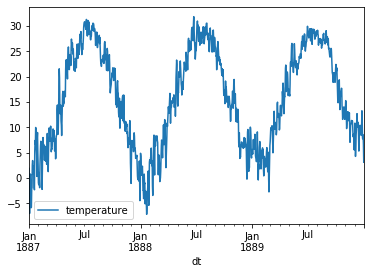

In [20]:
%matplotlib inline
df.groupby("dt").mean().plot();

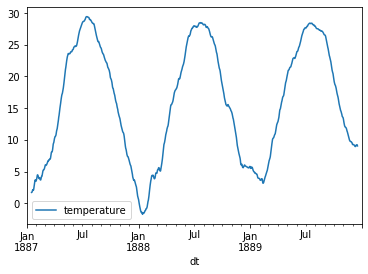

In [21]:
%matplotlib inline
df.groupby("dt").mean().rolling(window=30, center=True).mean().plot();